# Prototypage du modèle d'auto-encodeur

Ce notebook sert à :
1. Charger les fenêtres pré-traitées `windows.npy`.
2. Diviser en train/test
3. construire et entraîner un auto-encodeur simple (Keras)
4. Calculer l'erreur de reconstruction
5. Déterminer un seuil d'anomalie
6. Évaluer la détection d'anomalies et visualiser quelques cas

## 1. Imports et configuration

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape
from keras.optimizers import Adam
%matplotlib inline

## 2. Chargement des données

In [6]:
# Charger les fenêtres pré-traitées
windows = np.load('/home/arnaud/Documents/predictive_maintenance/data/processed/windows.npy') # (n_windows, windows_size, n_features)
print('Shape des windows:', windows.shape)

# Split en train/test (80/20)
X_train, X_test = train_test_split(windows, test_size=0.2, random_state=42)

Shape des windows: (1791, 100, 4)


## 3. Construction de l'auto-encodeur

In [7]:
window_size, n_feautures = X_train.shape[1], X_train.shape[2]

# Encodeur-Decodeur simple
input_layer = Input(shape=(window_size, n_feautures))
flat = Flatten()(input_layer)
encoded = Dense(units=64, activation='relu')(flat)
decoded = Dense(units=window_size * n_feautures, activation='sigmoid')(encoded)
output_layer = Reshape((window_size, n_feautures))(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 4)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,664 (201.81 KB)

 Trainable params: 51,664 (201.81 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Entraînement

In [8]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0541 - val_loss: 0.0079
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_l

## 5. Reconstruction et erreur

In [9]:
# Reconstruction sur train et test
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# Erreur MSE par fenêtre
mse_train = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))
mse_test = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))

# Déterminer seuil à partir  du quantile 95% des erreurs train
threshold = np.percentile(mse_train, 95)
print('Seuil d\'anomalie (95e percentile):', threshold)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Seuil d'anomalie (95e percentile): 0.007981826772904406


## 6. Détection d'anomalies

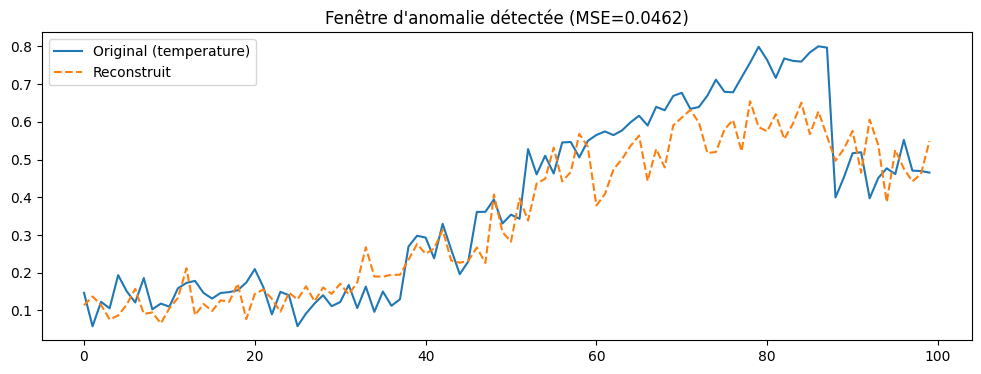

In [10]:
# Labels prédits (animalies si mse_test > threshold)
y_pred = mse_test > threshold

# Visualisation d'une fenêtre anormale
idx = np.argmax(mse_test)
window = X_test[idx]
recon = X_test_pred[idx]
t = np.arange(window_size)

plt.figure(figsize=(12, 4))
plt.plot(t, window[:, 0], label='Original (temperature)')
plt.plot(t, recon[:, 0], '--', label='Reconstruit')
plt.title(f'Fenêtre d\'anomalie détectée (MSE={mse_test[idx]:.4f})')
plt.legend()
plt.show()

## 7. Évaluation et visualisation

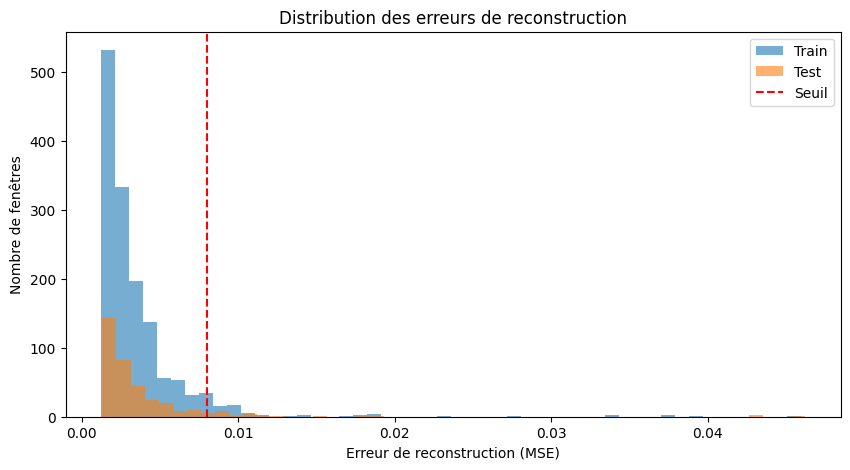

Proportion d'anomalies détectées dans le test : 6.96%


In [12]:
# Visualisation de la distribution des erreurs de reconstruction
plt.figure(figsize=(10,5))
plt.hist(mse_train, bins=50, alpha=0.6, label='Train')
plt.hist(mse_test, bins=50, alpha=0.6, label='Test')
plt.axvline(threshold, color='r', linestyle='--', label='Seuil')
plt.xlabel('Erreur de reconstruction (MSE)')
plt.ylabel('Nombre de fenêtres')
plt.title('Distribution des erreurs de reconstruction')
plt.legend()
plt.show()

# Proportion d'anomalies détectées dans le test
anomaly_ratio = np.mean(y_pred)
print(f"Proportion d'anomalies détectées dans le test : {anomaly_ratio:.2%}")